# Feature Importance Report of Algorithm and Implementation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.base import clone
import shap

In [2]:
%run featimp

## What is feature importance?
Feature importance is the assigned score of input features based on their importance to predict the output. By dropping unimportant features, we can simplify the model, increase pre-processing and modeling speed, and prevent overfitting to a certain extent. The ideal scenario is: we can pick the most predictive features, by implementing some methods. 

In this report, I am going to show six feature importance methods:
1. Spearman's Rank Correlation
2. Principle Component Analysis (PCA)
3. Minimal-redundancy-maximal-relevance (mRMR)
4. Drop-column Importance
5. Permutation Importance
6. SHapley Additive exPlanations (SHAP)

After methods introduction, I will show visualization of methods comparision, and how to select the most predictive features automatically. Also, I would like to demonstrate some statistical analysis, including standard deviation and empirical p-value for feature importances.

## Breast Cancer Wisconsin Data Set
The data set used is beast cancer dataset from UCI, which contains 569 observations of 32 attributes. The length of this data is moderate and all values are numeric, so it is good for us to use this dataset as a tutorial. Readers can try more complexed dataset which might has categorical variables and missing value. In that case, data-prepocessing might be considered before feature importance analysis.

Let's load the data first.

In [3]:
cancer = load_breast_cancer()
X_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y_df = pd.DataFrame(cancer.target, columns=["target"])
columns_name = list(cancer.feature_names) + ["target"]
cancer_df = pd.concat([X_df, y_df], ignore_index=True, sort=False, axis=1)
cancer_df.columns = columns_name
cancer_df.columns = cancer_df.columns.map(str)

In [4]:
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [5]:
cancer_df.shape

(569, 31)

Split train and validation dataset at 80:20 ratio. And use random_state 3 to reproduce model in the future.

In [6]:
train_df, val_df = train_test_split(cancer_df, test_size=0.2, random_state=3)

## Spearman's Rank Correlation

This is an importance regression feature importance by retriving their coefficient of Spearman's rank correlation. In general, it has better explanation than Pearson correlation, because Spearman correlation evaluates the ranked value of each variable rather than the raw data. So relationships between the feature and target, whether linear or not, is assessed by Spearman's rank correlation.

To implement this algorithm, for each feature and target, we need to use **covariance** of the rank to be devided by **standard deviation** of the rank. 

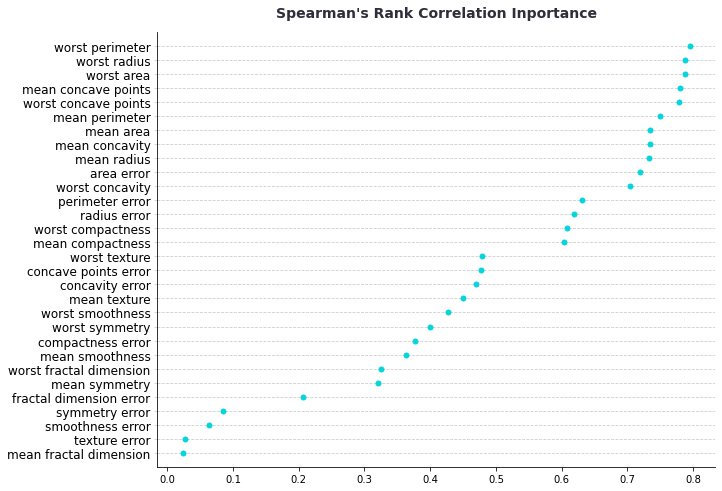

In [7]:
spearman_imp = spearman_rank_corr(train_df, 'target')
draw_cleveland_plot(spearman_imp, "Spearman's Rank Correlation Inportance")

The above plot is a style of Cleveland's dot plot, which is more reader-friendly.

## PCA
PCA uses orthogonal transformation to identify features that explain the most variance in the new space. In this way, we can use only a few principal components to represent the data's variation.

To implement PCA in python, we first need to scale the feature data.

In [8]:
scaler = StandardScaler()
train_feature_scaled = scaler.fit_transform(train_df.iloc[:, :-1])
val_feature_scaled = scaler.transform(val_df.iloc[:, :-1])

Then fit the scaled training feature data

In [9]:
pca = PCA(random_state=3)
pca.fit(train_feature_scaled)

PCA(random_state=3)

Now we can check all pinpical components. The default component number is the same as feature number.

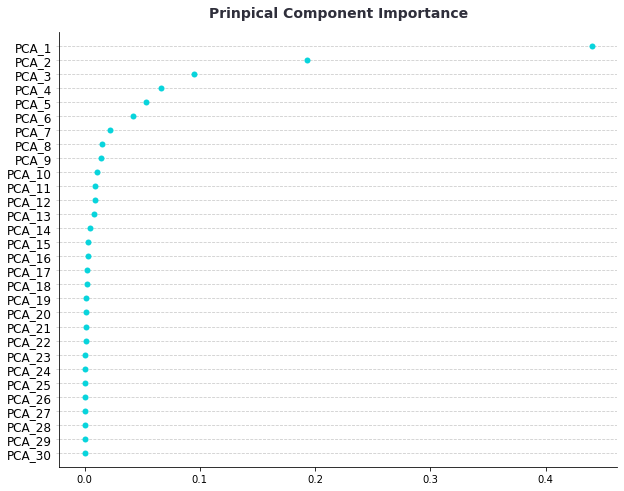

In [10]:
pca_array = pca.explained_variance_ratio_ 
categories = ['PCA_'+str(i) for i in range(1, len(pca_array)+1)]
pca_imp = dict(zip(categories, pca_array))

draw_cleveland_plot(pca_imp, "Prinpical Component Importance")

From the plot above, it is clear that the first principle component has a major explanation of the target. So we can extract the first component, and visualize the importance of each feature in this dimension.

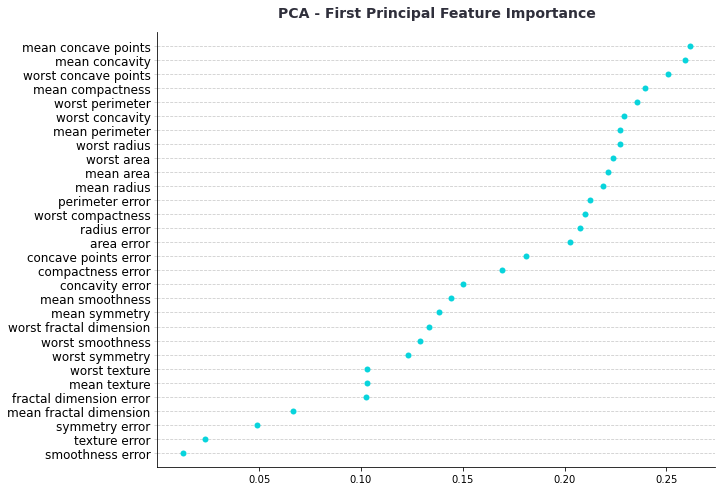

In [11]:
pca_first = pca.components_[0]
pca_first_imp = dict(zip(train_df.columns[:-1], pca_first))
pca_first_imp = dict(sorted(pca_first_imp.items(), key=lambda item: item[1], reverse=True))

draw_cleveland_plot(pca_first_imp, "PCA - First Principal Feature Importance")

## mRMR
mRMR is a good method to deal with codependencies, as it rank features not just by relevance but also by low redundancy. **Relevance** is the Spearman's rank correlation between one feature and target. **Redundancy** is measured by the mean of Spearman's rank correlation between one feature and each other feature. Then mRMR is calculated by substracting redundancy from relevance. Below is the math function.
![Minion](https://raw.githubusercontent.com/parrt/msds689/master/projects/featimp/mRMR.png)

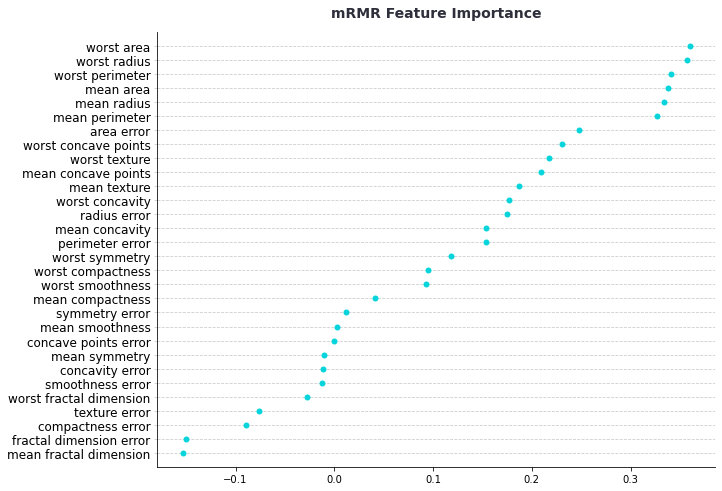

In [12]:
mRMR_imp = mRMR_corr(train_df, 'target')
draw_cleveland_plot(mRMR_imp, "mRMR Feature Importance")

## Drop-column
In this method, we first get a baseline metric, and then drop features one at a time, and retrain the model. The score is the change between new metric score and the baseline.

The algorithm is:
1. Compute validation metric for model trained on all features 
2. Drop column xj from training set 
3. Retrain model 
4. Compute validation metric set 
5. Importance score is the change in metric

In [13]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=3)

X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1]
X_val = val_df.iloc[:, :-1]
y_val = val_df.iloc[:, -1]

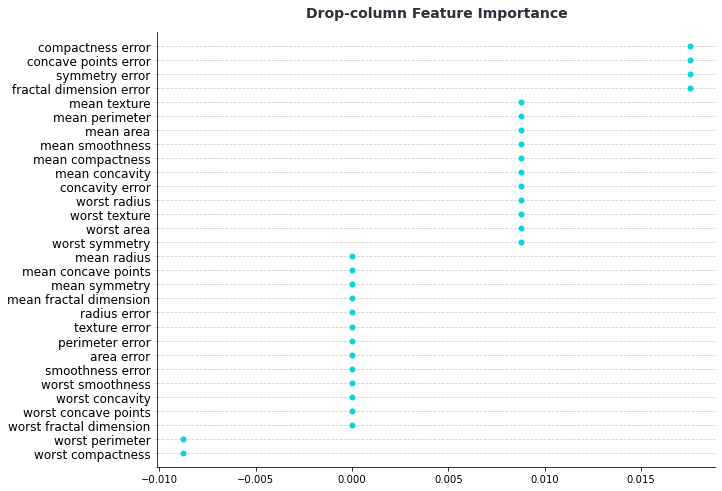

In [14]:
dropcol_imp = dropcol_importances(rf, X_train, y_train, 
                              X_val, y_val, metric=accuracy_score)
draw_cleveland_plot(dropcol_imp, "Drop-column Feature Importance")

## Permutation Importance
Instead of dropping the feature, in this method we permute the data in feature one column at a time. Below is the algothrim:
1. Compute validation metric for model trained on all features 
2. Permute column xj in validation set 
3. Compute validation metric set 
4. Importance score is the change in metric

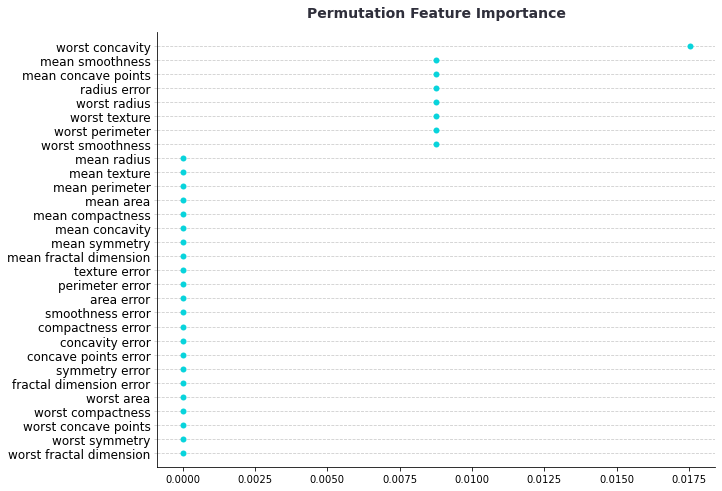

In [15]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=3)
permutation_imp = permutation_importances(rf, X_train, y_train, 
                              X_val, y_val, metric=accuracy_score)
draw_cleveland_plot(permutation_imp, "Permutation Feature Importance")

## SHAP
SHAP is a method to explain the contribution of each feature to the prediction. The idea of SHAP is based on the game theoreically optimal Shapley values.

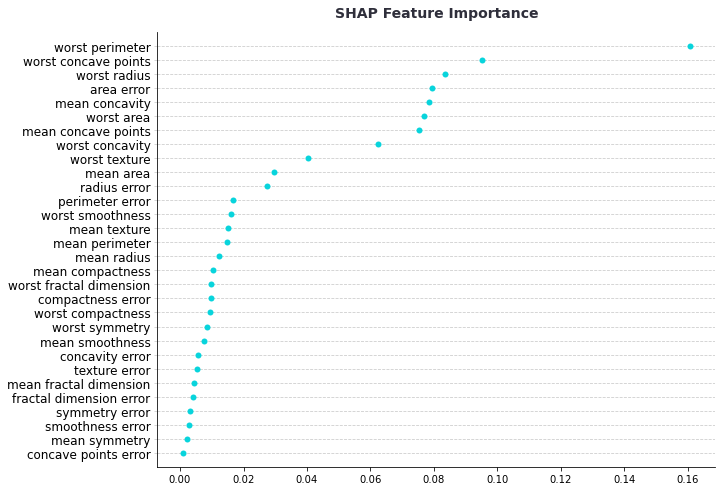

In [16]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=3)
rf.fit(X_train, y_train)
shap_explainer = shap.TreeExplainer(rf, data=X_train)
shap_value = shap_explainer.shap_values(X=X_val, y=y_val, check_additivity=False)

shap_imp_value = np.sum(np.mean(np.abs(shap_value), axis=1), axis=0)
shap_imp = dict(zip(train_df.columns[:-1], shap_imp_value))
shap_imp = dict(sorted(shap_imp.items(), key=lambda item: item[1], reverse=True))

draw_cleveland_plot(shap_imp, "SHAP Feature Importance")

## Compare strategies
Congratuations! We have reviewed so many feature importance techniques!

But you might ask: which strategy should we pick? Here I am comparing each method by cumulatively picking top features one at a time, and measuring the validation log loss of each step. The best model is the one that achives low loss with less number of features.

In [17]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=3)
loss_spearman = cumulate_feature_loss(rf, X_train, y_train, 
                                      X_val, y_val, spearman_imp)
loss_pca = cumulate_feature_loss(rf, X_train, y_train, 
                                      X_val, y_val, pca_first_imp)
loss_mRMR = cumulate_feature_loss(rf, X_train, y_train, 
                                      X_val, y_val, mRMR_imp)
loss_dropcol = cumulate_feature_loss(rf, X_train, y_train, 
                                      X_val, y_val, dropcol_imp)
loss_permutation = cumulate_feature_loss(rf, X_train, y_train, 
                                      X_val, y_val, permutation_imp)
loss_shap = cumulate_feature_loss(rf, X_train, y_train, 
                                      X_val, y_val, shap_imp)

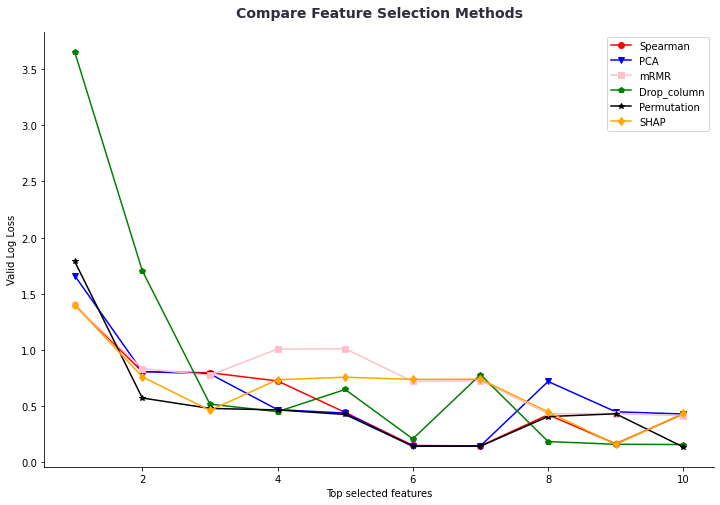

In [18]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(12,8))
x_label_list = list(range(1, len(loss_spearman)+1))
ax.plot(x_label_list, loss_spearman, 'red', marker='o',  label='Spearman')
ax.plot(x_label_list, loss_pca, 'blue', marker='v',  label='PCA')
ax.plot(x_label_list, loss_mRMR, 'pink', marker='s',  label='mRMR')
ax.plot(x_label_list, loss_dropcol, 'green', marker='p',  label='Drop_column')
ax.plot(x_label_list, loss_permutation, 'black', marker='*',  label='Permutation')
ax.plot(x_label_list, loss_shap, 'orange', marker='d',  label='SHAP')

ax.legend()
ax.set_ylabel('Valid Log Loss', fontsize=10)
ax.set_xlabel('Top selected features', fontsize=10)
ax.set_title("Compare Feature Selection Methods", 
             y=1.02, color ='#2F2F3B', fontsize=14, weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Automatic feature selection
After selecting the feature importance measurement method, we can do feature selection. Here I am using SHAP method to select features. We cumulatively drop low score feature one at a time, retrain the model and culculate the log loss. The log loss will initially decrease, and when it bounces back, we stop the iteration, and dropped features are those in the last step.

In [19]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=3)
feat_selected = feat_select(rf, X_train, y_train, X_val, y_val, 
            shap_imp, loss_metric=log_loss)

Loop 1, drop feature: concave points error
	Loss decrease: 0.432 -> 0.1322
Loop 2, drop feature: mean fractal dimension
	Loss increase: 0.1322 -> 0.1434

Drop features: ['concave points error']
Select features: ['worst area', 'worst radius', 'worst perimeter', 'worst concavity', 'worst concave points', 'mean area', 'area error', 'mean concavity', 'mean concave points', 'worst texture', 'worst smoothness', 'mean texture', 'mean radius', 'mean perimeter', 'worst compactness', 'perimeter error', 'mean compactness', 'mean smoothness', 'radius error', 'compactness error', 'symmetry error', 'worst symmetry', 'texture error', 'worst fractal dimension', 'concavity error', 'fractal dimension error', 'smoothness error', 'mean symmetry', 'mean fractal dimension']


## Standard Deviation of Feature Importance
To better understand the nature of feature importance, we can do some statistical analysis. The first one is calculating standard deviation by boostrapping data. Here I am using SHAP importance as an example, and boostrap 100 times.

In [20]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=3)
shap_imp_std_dict = feat_std(rf, X_train,y_train, 
         X_val, y_val)

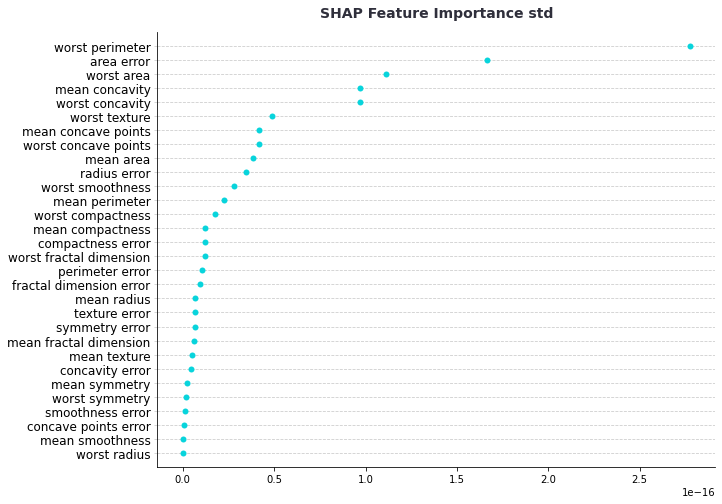

In [21]:
draw_cleveland_plot(shap_imp_std_dict, "SHAP Feature Importance std")

## Empirical P-Values
Another interesting statistical analysis is empirical p-values. We first calculate the importance as a baseline (null distribution), then shuffle the target data, and re-calculate the feature importance. The empirical p-value is measured by how many times a feature is as important or more important than the baseline. If that percentage gets above 5%, then that feature importance is not significant. Here I am using SHAP importance as an example, and shuffling target data 500 times.

In [22]:
rf = RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=3)
p_values, shap_baseline, shap_imp_array = get_p_values(rf, X_train, y_train, 
                                                  X_val, y_val)

Below are empirical significant features.

In [23]:
get_significant_col(p_values, X_train)

{('mean concavity', 0.0): 6,
 ('mean concave points', 0.006): 7,
 ('area error', 0.0): 13,
 ('worst radius', 0.0): 20,
 ('worst perimeter', 0.0): 22,
 ('worst area', 0.0): 23,
 ('worst concavity', 0.018): 26,
 ('worst concave points', 0.0): 27}

Let's visualize a significant feature.

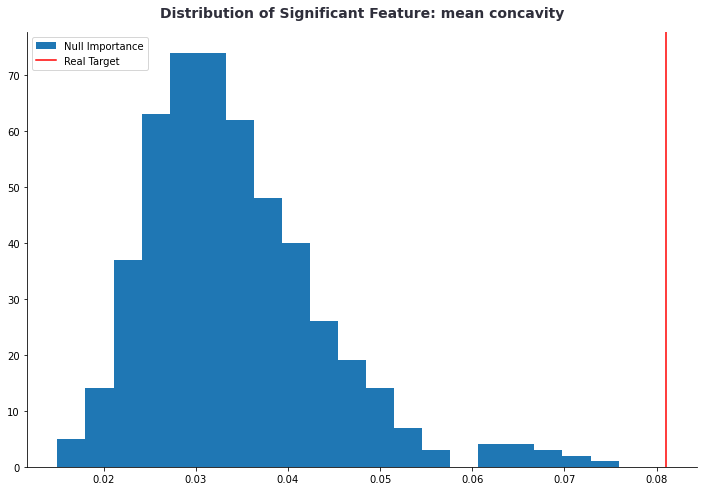

In [24]:
col_order = 6
fig,ax = plt.subplots(1, 1, figsize=(12,8))
ax.hist(shap_imp_array[:, col_order], bins=20, 
        label="Null Importance")
ax.axvline(x=shap_baseline[col_order], c='r', 
           label='Real Target')

ax.legend()
ax.set_title(
    f"Distribution of Significant Feature: {X_train.columns[col_order]}", 
             y=1.02, color ='#2F2F3B', fontsize=14, weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Another visualization of one insignificant feature.

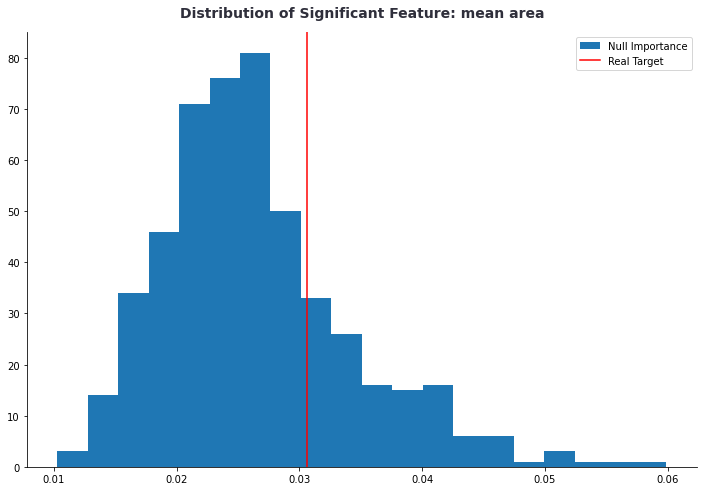

In [26]:
col_order = 3
fig,ax = plt.subplots(1, 1, figsize=(12,8))
ax.hist(shap_imp_array[:, col_order], bins=20, 
        label="Null Importance")
ax.axvline(x=shap_baseline[col_order], c='r', 
           label='Real Target')

ax.legend()
ax.set_title(
    f"Distribution of Insignificant Feature: {X_train.columns[col_order]}", 
             y=1.02, color ='#2F2F3B', fontsize=14, weight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()